<a href="https://colab.research.google.com/github/dr-irani/cs682-final-project/blob/master/notebooks/MSRP_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [6]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [7]:
!pip install transformers

     |████████████████████████████████| 645kB 5.9MB/s 
     |████████████████████████████████| 3.8MB 9.2MB/s 
     |████████████████████████████████| 1.0MB 42.4MB/s 
     |████████████████████████████████| 890kB 36.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5d25cd0beb8738bd4be1ed1cf46bf1a70bd12de87e994b715afff5fd1e2fb043
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Deep Learning/MSRP_all_data.csv')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sentences1 = df['#1 String'].values
sentences2 = df['#2 String'].values
labels = df.Quality.values


In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
sent1 = []
sent2 = []
labs = []
for i in range(len(sentences1)):
  if type(sentences1[i]) == str and type(sentences2[i]) == str: 
    sent1.append(sentences1[i])
    sent2.append(sentences2[i])
    labs.append(labels[i])

In [0]:
max_len = 0
# For every sentence...
for sent in sent1:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  52


In [0]:
for sent in sent2:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  54


In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for i in range(len(sent1)):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent1[i], 
                        sent2[i],                     # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sent1[0])
print('Original: ', sent2[0])
print('Token IDs:', input_ids[0])

Original:  Amrozi accused his brother, whom he called "the witness", of deliberately distorting his evidence.
Original:  Referring to him as only "the witness", Amrozi accused his brother of deliberately distorting his evidence.
Token IDs: tensor([  101,  2572,  3217,  5831,  5496,  2010,  2567,  1010,  3183,  2002,
         2170,  1000,  1996,  7409,  1000,  1010,  1997,  9969,  4487, 23809,
         3436,  2010,  3350,  1012,   102,  7727,  2000,  2032,  2004,  2069,
         1000,  1996,  7409,  1000,  1010,  2572,  3217,  5831,  5496,  2010,
         2567,  1997,  9969,  4487, 23809,  3436,  2010,  3350,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [0]:
import numpy as np
labs = np.array(labs)
labels = torch.from_numpy(labs)

In [0]:
print(type(labels))

print(type(input_ids))
print(type(attention_masks))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,182 training samples
  576 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random
import numpy as np
import os
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
prev_val_loss = 0 
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):        
        if step % 40 == 0 and not step == 0:          
            elapsed = format_time(time.time() - t0)            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()      
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    
    # If validation loss is lower than previous, save the model.
    if avg_val_loss <=  prev_val_loss:
      output_dir = './model_save/'

      if not os.path.exists(output_dir):
        os.makedirs(output_dir)
      print("Saving model to %s" % output_dir)

      # Save a trained model, configuration and tokenizer using `save_pretrained()`.
      # They can then be reloaded using `from_pretrained()`
      best_model = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
      best_model.save_pretrained(output_dir)
      tokenizer.save_pretrained(output_dir)
    prev_val_loss = avg_val_loss
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    162.    Elapsed: 0:00:25.
  Batch    80  of    162.    Elapsed: 0:00:51.
  Batch   120  of    162.    Elapsed: 0:01:17.
  Batch   160  of    162.    Elapsed: 0:01:43.

  Average training loss: 0.10
  Training epcoh took: 0:01:44

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.52
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    162.    Elapsed: 0:00:26.
  Batch    80  of    162.    Elapsed: 0:00:52.
  Batch   120  of    162.    Elapsed: 0:01:17.
  Batch   160  of    162.    Elapsed: 0:01:43.

  Average training loss: 0.10
  Training epcoh took: 0:01:45

Running Validation...
  Accuracy: 0.82
  Validation Loss: 0.52
  Validation took: 0:00:04
Saving model to ./model_save/

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    162.    Elapsed: 0:00:26.
  Batch    80  of    162.    Elapsed: 0:00:52.
  Batch   120  of    162.    Elapsed: 0:01:17.
  Batch   160  of 

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.10,0.52,0.82,0:01:44,0:00:04
2,0.10,0.52,0.82,0:01:45,0:00:04
3,0.16,0.52,0.82,0:01:45,0:00:04
4,0.18,0.52,0.82,0:01:45,0:00:04


In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/Deep Learning/BERT Fine-Tuning/MRPC"

In [0]:
from compute_seat import SEAT, create_target_attribute_lists, A_words, B_words

with open('/content/drive/My Drive/Deep Learning/Names/40_white_names.txt', 'r') as f:
    X_words = f.read().splitlines()
with open('/content/drive/My Drive/Deep Learning/Names/40_black_names.txt', 'r') as f:
    Y_words = f.read().splitlines()

A, B, X, Y = create_target_attribute_lists(X_words, Y_words, A_words, B_words)
seat = SEAT('./drive/My Drive/Deep Learning/BERT Fine-Tuning/MRPC/model_save/')
m, seat_score, effect_size = seat.run_seat(A, B, X, Y)

In [10]:
m, seat_score, effect_size

(array([[0.99300308, 0.99106856, 0.98525629, 0.9903675 , 0.99007647,
         0.97605129, 0.9938464 , 0.9935895 , 0.98503558, 0.99363212,
         0.99355174, 0.98235818, 0.98949177, 0.98951746, 0.97612121,
         0.98961757, 0.99044075, 0.98105842, 0.99070391, 0.9908385 ,
         0.9808297 , 0.98986975, 0.98918451, 0.97638358, 0.98674595,
         0.98914991, 0.97727163, 0.99358126, 0.99175488, 0.98366201,
         0.99641941, 0.99723533, 0.9887842 , 0.9936245 , 0.99352169,
         0.98325376, 0.99482019, 0.99480343, 0.98698937, 0.99205198,
         0.993134  , 0.98115653, 0.98932187, 0.98960564, 0.9806163 ,
         0.99289499, 0.9931948 , 0.98086641, 0.98865076, 0.99317375,
         0.9823944 , 0.99004123, 0.99138419, 0.98330576],
        [0.99074832, 0.98447118, 0.98714238, 0.9878613 , 0.98419022,
         0.97728047, 0.99084232, 0.98743023, 0.98674628, 0.99121719,
         0.98769218, 0.98436196, 0.98708277, 0.98368252, 0.97750343,
         0.98739333, 0.98478382, 0.98257914, 

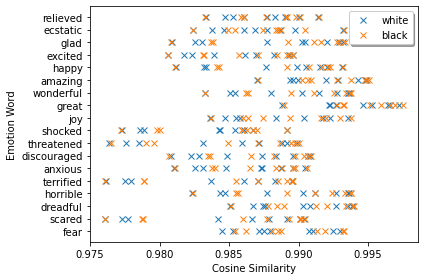

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# attributes: A - fear, B - joy
# target: X - white names, Y - black names
targ_size = len(X)
attr_size = len(A)

fig = plt.figure()
ax = plt.subplot(111)
emotions = A_words + B_words

for i in range(m.shape[0]):
  if i < targ_size:
    race = "white"
    c = 'C0'
  else:
    race = "black"
    c = 'C1'    
  for j in range(m.shape[1]):
    ax.plot(m[i, j], emotions[j//3], 'x', color=c, label=race if (i==0 or i==targ_size) and j==0 else "")

# for i in range(targ_size, m.shape[0]):
#   for j in range(m.shape[1]):
#     ax.plot(m[i, j], emotions[j//3], 'x', c = 'orange', label='black')

ax.legend(loc='best', ncol=1, fancybox=True, shadow=True)
plt.xlabel('Cosine Similarity')
plt.ylabel('Emotion Word')
plt.tight_layout()
#plt.savefig('/content/names_seat.png')